#Predictive-Deep-Learning-for-Pitting-Corrosion
###by https://github.com/HMesghali


## Introduction

This project aims to predict the maximum depth of pitting corrosion in oil and gas pipelines using deep learning models. The study focuses on Generalization and Generalization-Memorization models, considering various soil characteristics and pipe protective coatings. The goal is to enhance the safety and reliability of pipelines by predicting failure rates due to external corrosion.

**Note:** This is a replication of the original study with some changes, as the main code is no longer available. However, the models are still performing well.

**Note:** This code might be changed in future for having higher quality images

Jupyter Notebook: Code for data preprocessing, model training, and evaluation.

**Dataset** : Pitting Corrosion of Underground Pipelines Related to Local Soil and Pipe Characteristics

**Dataset Link**: https://www.researchgate.net/publication/318835278_Pitting_Corrosion_of_Underground_Pipelines_Related_to_Local_Soil_and_Pipe_Characteristics

**Paper Link**: https://www.sciencedirect.com/science/article/pii/S0957582023002975

Important Credit Information: If you plan to use this dataset in your own projects, please ensure that you provide appropriate credit to the individuals and organizations responsible for its collection and curation. Proper attribution not only respects the hard work of the original authors but also promotes academic integrity and collaboration within the research community.

## Importing necessary packages and trying to make the code reproducable

In [6]:
# Import the pandas library, aliasing it as 'pd' for convenience.
import pandas as pd

# Import the NumPy library, aliasing it as 'np' for convenience.
import numpy as np

# Import the matplotlib.pyplot module, aliasing it as 'plt' for convenience.
# This is used for creating static, animated, and interactive visualizations.
import matplotlib.pyplot as plt

# Import the TensorFlow library, aliasing it as 'tf' for convenience.
# TensorFlow is an open-source machine learning library.
import tensorflow as tf

# Import various modules from scikit-learn's model_selection package.
# These modules are used for splitting data into training and testing sets.
from sklearn.model_selection import *

# Import the MinMaxScaler class from scikit-learn's preprocessing package.
# This class is used to scale and normalize features in a dataset.
from sklearn.preprocessing import MinMaxScaler

# Import all metrics from scikit-learn's metrics package.
# These metrics are used to evaluate the performance of machine learning models.
from sklearn.metrics import *


In [7]:
# Import the pkg_resources module to access installed packages.
import pkg_resources

# Define a function to get a dictionary of installed packages and their versions.
def get_installed_packages():
    # Get the working set of installed packages.
    installed_packages = pkg_resources.working_set
    # Return a dictionary with package names as keys and versions as values.
    return {package.key: package.version for package in installed_packages}

# Get the dictionary of installed packages.
dependencies = get_installed_packages()

# List of required packages for the project.
required_packages = ['pandas', 'numpy', 'matplotlib', 'tensorflow', 'scikit-learn']

# Open the requirements.txt file in write mode.
with open('requirements.txt', 'w') as f:
    # Iterate over the required packages and write them to the file if they are installed.
    for package in required_packages:
        if package in dependencies:
            # Write the package name and version to the file.
            f.write(f"{package}=={dependencies[package]}\n")



with open("requirements.txt", "r") as f:
    print(f.read())

pandas==2.2.2
numpy==2.0.2
matplotlib==3.10.0
tensorflow==2.18.0
scikit-learn==1.6.1



In [8]:
# Weight initialization in deep learning models is inherently random, which can
# lead to variability in model performance across different runs.
# However, this randomness can be controlled to some degree to ensure
# reproducibility of results.

# For a comprehensive guide on controlling randomness and achieving
# reproducibility in Keras models, you can refer to the following link:
# https://keras.io/examples/keras_recipes/reproducibility_recipes/

# Notice that we did not include the process of fixing the seed in the main paper.
# Therefore, some results might vary between runs.

# Set a fixed seed to control the randomness in weight initialization and other
# random operations. This ensures that the model weights are initialized with
# the same values in subsequent runs, enhancing reproducibility.
tf.keras.utils.set_random_seed(42)


## Data Loading and Preprocessing

In [11]:
# Read the dataset from the CSV file.
df = pd.read_csv("SewagePipe_Data_Complete.csv")

# Clean the data to ensure all columns are in the correct format.
# Remove any trailing '?' characters from the 'PipeSoilPotential' column and convert it to float.
df["PipeSoilPotential"] = df["PipeSoilPotential"].str.strip("?").astype(float)

# Replace '<1.00' with '0' in the 'DissolvedChloride' column and convert it to float.
df["DissolvedChloride"] = df["DissolvedChloride"].replace(['<1.00'], '0').astype(float)

# Replace '<1.00' with '0' in the 'Bicarbonate' column and convert it to float.
df["Bicarbonate"] = df["Bicarbonate"].replace(['<1.00'], '0').astype(float)

# Remove commas and replace '<1.00' with '0' in the 'SulfateConcentration' column, then convert it to float.
df["SulfateConcentration"] = df["SulfateConcentration"].str.replace(',', '').replace(['<1.00'], '0').astype(float)

# Convert categorical columns to dummy variables using one-hot encoding.
# The 'drop_first=True' parameter is used to avoid multicollinearity by dropping
# the first category. The 'dtype=int' parameter ensures the dummy variables are integers.
df = pd.get_dummies(df, drop_first=True, dtype=int)

# Remove duplicate rows to prevent data leakage.
df = df.drop_duplicates()

# Separate the input features from the target variable.
TARGET = "MaxPitDepth"
y = df[TARGET]
X = df.drop(columns=[TARGET])

# Split the data into training, validation, and test sets.
# The test set size is set to 45 samples, and the remaining data is split between
# training and validation sets.
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=45,
    random_state=42
)

# Further split the training set into training and validation sets.
# The first 155 samples are used for training, and the next 45 samples are used
# for validation.
X_train, X_valid = X_train[:155], X_train[155:]
y_train, y_valid = y_train[:155], y_train[155:]

# Normalize the input features using Min-Max Scaler.
mms = MinMaxScaler()
X_train_scaled = mms.fit_transform(X_train)
X_valid_scaled = mms.transform(X_valid)
X_test_scaled = mms.transform(X_test)

# Normalize the target variable by scaling it between 0 and 1.
# This is done to ensure consistent scaling across all sets.
target_max, target_min = y_train.max(), y_train.min()
y_train_scaled = (y_train - target_min) / (target_max - target_min)
y_test_scaled = (y_test - target_min) / (target_max - target_min)
y_valid_scaled = (y_valid - target_min) / (target_max - target_min)


# Model Deployment

## Generalization Model

In [12]:
# Create the neural network model using the Sequential API.
# This model is designed for generalization and uses multiple dense layers with
# dropout for regularization.

# Define the weight initializer using He Normal initialization with a fixed seed for reproducibility.
initializer_1 = tf.keras.initializers.HeNormal(seed=42)

# Define the model architecture.
model_1 = tf.keras.models.Sequential([
    # First dense layer with 15 neurons, using ELU activation, and He Normal initialization.
    # The input shape is set based on the number of features in the training data.
    tf.keras.layers.Dense(15, activation='elu', input_shape=(X_train_scaled.shape[1],), kernel_initializer=initializer_1),

    # Dropout layer with a dropout rate of 0.2 to prevent overfitting.
    tf.keras.layers.Dropout(0.2),

    # Second dense layer with 15 neurons, using ELU activation, and He Normal initialization.
    tf.keras.layers.Dense(15, activation='elu', kernel_initializer=initializer_1),

    # Dropout layer with a dropout rate of 0.2 to prevent overfitting.
    tf.keras.layers.Dropout(0.2),

    # Third dense layer with 15 neurons, using ELU activation, and He Normal initialization.
    tf.keras.layers.Dense(15, activation='elu', kernel_initializer=initializer_1),

    # Dropout layer with a dropout rate of 0.2 to prevent overfitting.
    tf.keras.layers.Dropout(0.2),

    # Fourth dense layer with 15 neurons, using ELU activation, and He Normal initialization.
    tf.keras.layers.Dense(15, activation='elu', kernel_initializer=initializer_1),

    # Dropout layer with a dropout rate of 0.2 to prevent overfitting.
    tf.keras.layers.Dropout(0.2),

    # Final output layer with a single neuron, using Glorot Normal initialization for the weights.
    tf.keras.layers.Dense(1, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=42))
])

# Compile the model with the Adam optimizer and mean squared error (MSE) as the loss function.
# Mean absolute error (MAE) is included as an additional metric for evaluation.
model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Define an early stopping callback to stop training when the validation loss stops improving.
# The model will restore the best weights based on the validation loss.
# Not Implemented in the main paper. However, It's a good practice to do so
early_stopping_1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss.
    patience=100,        # Stop training if the validation loss does not improve for 100 epochs.
    restore_best_weights=True  # Restore the model weights that resulted in the best validation loss.
)

# Train the model on the scaled training data.
# The model is trained for up to 1000 epochs with a batch size of 20.
# Validation data is used to monitor the model's performance during training.
history_1 = model_1.fit(
    X_train_scaled,      # Scaled training input features.
    y_train_scaled,      # Scaled training target variable.
    epochs=1000,         # Maximum number of training epochs.
    batch_size=20,       # Batch size for training.
    validation_data=(X_valid_scaled, y_valid_scaled),  # Validation data for monitoring.
    verbose=0,           # Suppress training output.
    callbacks=[early_stopping_1]  # Apply the early stopping callback.
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Generalization and Memorization Model

In [13]:
# Create the neural network model using the Functional API for both generalization and memorization.
# This model architecture includes a concatenation layer to combine the input and intermediate features.

# Define the weight initializer using He Normal initialization with a fixed seed for reproducibility.
initializer_2 = tf.keras.initializers.HeNormal(seed=1024)

# Define the input layer with the shape based on the number of features in the training data.
input_ = tf.keras.layers.Input(shape=(X_train_scaled.shape[1],))

# First dense layer with 15 neurons, using ReLU activation, and He Normal initialization.
x = tf.keras.layers.Dense(15, activation='relu', kernel_initializer=initializer_2)(input_)

# Second dense layer with 15 neurons, using ReLU activation, and He Normal initialization.
x = tf.keras.layers.Dense(15, activation='relu', kernel_initializer=initializer_2)(x)

# Third dense layer with 15 neurons, using ReLU activation, and He Normal initialization.
x = tf.keras.layers.Dense(15, activation='relu', kernel_initializer=initializer_2)(x)

# Concatenate the input features with the output of the third dense layer.
# This step is done outside the model definition to allow for concatenation.
concat_layer = tf.keras.layers.Concatenate()([input_, x])

# Final output layer with a single neuron
output = tf.keras.layers.Dense(1, kernel_initializer=tf.keras.initializers.glorot_normal(1024))(concat_layer)

# Define the model using the input and output layers.
model_2 = tf.keras.Model(inputs=[input_], outputs=[output])

# Compile the model with the Adam optimizer and mean squared error (MSE) as the loss function.
# Mean absolute error (MAE) is included as an additional metric for evaluation.
model_2.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Define an early stopping callback to stop training when the validation loss stops improving.
# The model will restore the best weights based on the validation loss.
# Not Implemented in the main paper. However, It's a good practice to do so
early_stopping_2 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss.
    patience=100,        # Stop training if the validation loss does not improve for 100 epochs.
    restore_best_weights=True  # Restore the model weights that resulted in the best validation loss.
)

# Train the model on the scaled training data.
# The model is trained for up to 1000 epochs with a batch size of 20.
# Validation data is used to monitor the model's performance during training.
history_2 = model_2.fit(
    X_train_scaled,      # Scaled training input features.
    y_train_scaled,      # Scaled training target variable.
    epochs=1000,         # Maximum number of training epochs.
    batch_size=20,       # Batch size for training.
    validation_data=(X_valid_scaled, y_valid_scaled),  # Validation data for monitoring.
    verbose=0,            # Suppress training output.
    callbacks=[early_stopping_2]  # Apply the early stopping callback (currently commented out).
)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10']
Received: inputs=Tensor(shape=(None, 19))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_10']
Received: inputs=Tensor(shape=(None, 19))
  warnings.warn(msg)


# Results and Visualizations

## Plotting  the Process of Training

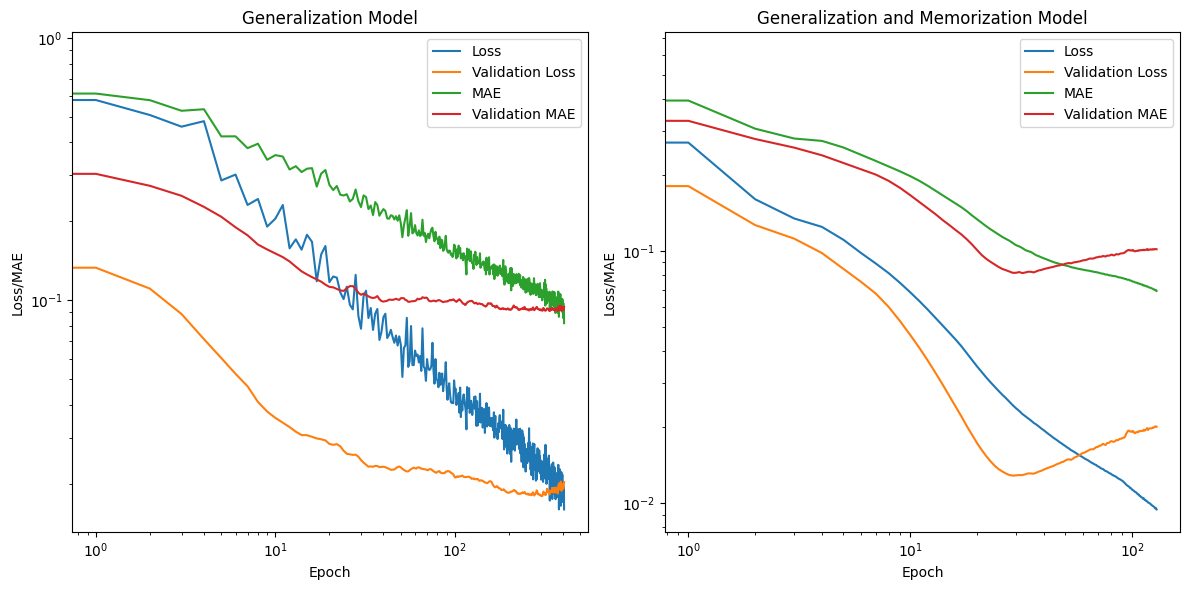

In [20]:
# Plot the training and validation loss and mean absolute error (MAE) for both models over the epochs.
# Note that in the main paper, the log scale was not implemented, which would have provided a better demonstration of the model's performance.

# Create a figure with a specified size to hold the subplots.
plt.figure(figsize=(12, 6))

# Create the first subplot for Model 1.
plt.subplot(1, 2, 1)

# Plot the training loss of Model 1.
plt.plot(history_1.history['loss'], label='Loss')

# Plot the validation loss of Model 1.
plt.plot(history_1.history['val_loss'], label='Validation Loss')

# Plot the training MAE of Model 1.
plt.plot(history_1.history['mae'], label='MAE')

# Plot the validation MAE of Model 1.
plt.plot(history_1.history['val_mae'], label='Validation MAE')

# Set the x-axis label.
plt.xlabel('Epoch')

# Set the y-axis label.
plt.ylabel('Loss/MAE')

# Set the title for the subplot.
plt.title('Generalization Model')

# Add a legend to the subplot.
plt.legend()

# Use a log scale for the y-axis to better visualize the error values.
plt.yscale("log")

# Use a log scale for the x-axis to better visualize the epoch progression.
plt.xscale("log")


# Create the second subplot for Model 2.
plt.subplot(1, 2, 2)

# Plot the training loss of Model 2.
plt.plot(history_2.history['loss'], label='Loss')

# Plot the validation loss of Model 2.
plt.plot(history_2.history['val_loss'], label='Validation Loss')

# Plot the training MAE of Model 2.
plt.plot(history_2.history['mae'], label='MAE')

# Plot the validation MAE of Model 2.
plt.plot(history_2.history['val_mae'], label='Validation MAE')

# Set the x-axis label.
plt.xlabel('Epoch')

# Set the y-axis label.
plt.ylabel('Loss/MAE')

# Set the title for the subplot.
plt.title('Generalization and Memorization Model')

# Add a legend to the subplot.
plt.legend()

# Use a log scale for the y-axis to better visualize the error values.
plt.yscale("log")

# Use a log scale for the x-axis to better visualize the epoch progression.
plt.xscale("log")

# Adjust the layout so that the subplots fit well within the figure.
plt.tight_layout()

# Display the plot.
plt.show()


## Plotting the Architecture of Models

In [21]:
# Use the following code to visualize and plot the architecture of the models.
# Uncomment the lines to generate the plots.

# Plot the architecture of Model 1 (Generalization model) and save it to a file.
# The 'show_shapes=True' parameter displays the input and output shapes of each layer.
# The 'show_layer_names=True' parameter displays the names of each layer.
# The plot is saved to a file named 'generalization_model.png'.
# tf.keras.utils.plot_model(model_1, show_shapes=True, show_layer_names=True, to_file='generalization_model.png')

# Plot the architecture of Model 2 (Generalization and Memorization model) and save it to a file.
# The 'show_shapes=True' parameter displays the input and output shapes of each layer.
# The 'show_layer_names=True' parameter displays the names of each layer.
# The plot is saved to a file named 'gen_mem_model.png'.
# tf.keras.utils.plot_model(model_2, show_shapes=True, show_layer_names=True, to_file='gen_mem_model.png')


## Performance Analysis (MAE, MSE, RMSE)

In [22]:
# Note that in the main paper, only scaled predictions are included for comparison with previous papers.

# Predict the output for the training and test sets using Model 1 (Generalization) on scaled data.
y_train_pred_scaled_model_1 = model_1.predict(X_train_scaled, verbose=0)
y_test_pred_scaled_model_1 = model_1.predict(X_test_scaled, verbose=0)

# Reverse the scaling of the predictions to get the original scale.
# This is done by multiplying by the range of the target variable and adding the minimum value.
y_train_pred_model_1 = y_train_pred_scaled_model_1 * (target_max - target_min) + target_min
y_test_pred_model_1 = y_test_pred_scaled_model_1 * (target_max - target_min) + target_min

# Predict the output for the training and test sets using Model 2 (Generalization and Memorization) on scaled data.
y_train_pred_scaled_model_2 = model_2.predict(X_train_scaled, verbose=0)
y_test_pred_scaled_model_2 = model_2.predict(X_test_scaled, verbose=0)

# Reverse the scaling of the predictions to get the original scale.
# This is done by multiplying by the range of the target variable and adding the minimum value.
y_train_pred_model_2 = y_train_pred_scaled_model_2 * (target_max - target_min) + target_min
y_test_pred_model_2 = y_test_pred_scaled_model_2 * (target_max - target_min) + target_min


def calculate_metrics_and_create_df(model_name, y_train, y_test, y_train_pred, y_test_pred, version):
    """
    Calculates the Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE)
    for the given model and dataset, and creates a DataFrame to store these metrics.

    Parameters:
        model_name (str): The name of the model.
        y_train (array): The actual training target values.
        y_test (array): The actual test target values.
        y_train_pred (array): The predicted training target values.
        y_test_pred (array): The predicted test target values.
        version (str): Whether the predictions are scaled or not scaled.

    Returns:
        results_df (DataFrame): A DataFrame containing the calculated metrics.
    """
    # Calculate the Mean Squared Error (MSE) for the training and test sets.
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Calculate the Root Mean Squared Error (RMSE) for the training and test sets.
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    # Calculate the Mean Absolute Error (MAE) for the training and test sets.
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Create a DataFrame to store the calculated metrics.
    results_df = pd.DataFrame({
        'Dataset': ['Train', 'Test'],
        'MSE': [train_mse, test_mse],
        'RMSE': [train_rmse, test_rmse],
        'MAE': [train_mae, test_mae]
    })

    # Add the model name and version to the DataFrame.
    results_df['Model'] = model_name
    results_df['Version'] = version

    return results_df


# Initialize an empty DataFrame to store the results.
results_df = pd.DataFrame()

# Calculate and append the metrics for Model 1 (Generalization) using unscaled predictions.
results_df = pd.concat([results_df, calculate_metrics_and_create_df("Model_1", y_train, y_test, y_train_pred_model_1, y_test_pred_model_1, "Not Scaled")])

# Calculate and append the metrics for Model 1 (Generalization) using scaled predictions.
results_df = pd.concat([results_df, calculate_metrics_and_create_df("Model_1", y_train_scaled, y_test_scaled, y_train_pred_scaled_model_1, y_test_pred_scaled_model_1, "Scaled")])

# Calculate and append the metrics for Model 2 (Generalization and Memorization) using unscaled predictions.
results_df = pd.concat([results_df, calculate_metrics_and_create_df("Model_2", y_train, y_test, y_train_pred_model_2, y_test_pred_model_2, "Not Scaled")])

# Calculate and append the metrics for Model 2 (Generalization and Memorization) using scaled predictions.
results_df = pd.concat([results_df, calculate_metrics_and_create_df("Model_2", y_train_scaled, y_test_scaled, y_train_pred_scaled_model_2, y_test_pred_scaled_model_2, "Scaled")])


# Print the resulting DataFrame containing all the calculated metrics.
print(results_df)


  Dataset       MSE      RMSE       MAE    Model     Version
0   Train  1.659444  1.288194  0.803994  Model_1  Not Scaled
1    Test  0.973899  0.986863  0.724366  Model_1  Not Scaled
0   Train  0.016594  0.128819  0.080399  Model_1      Scaled
1    Test  0.009739  0.098686  0.072437  Model_1      Scaled
0   Train  2.381823  1.543316  1.052380  Model_2  Not Scaled
1    Test  2.632715  1.622564  1.180954  Model_2  Not Scaled
0   Train  0.023818  0.154332  0.105238  Model_2      Scaled
1    Test  0.026327  0.162256  0.118095  Model_2      Scaled


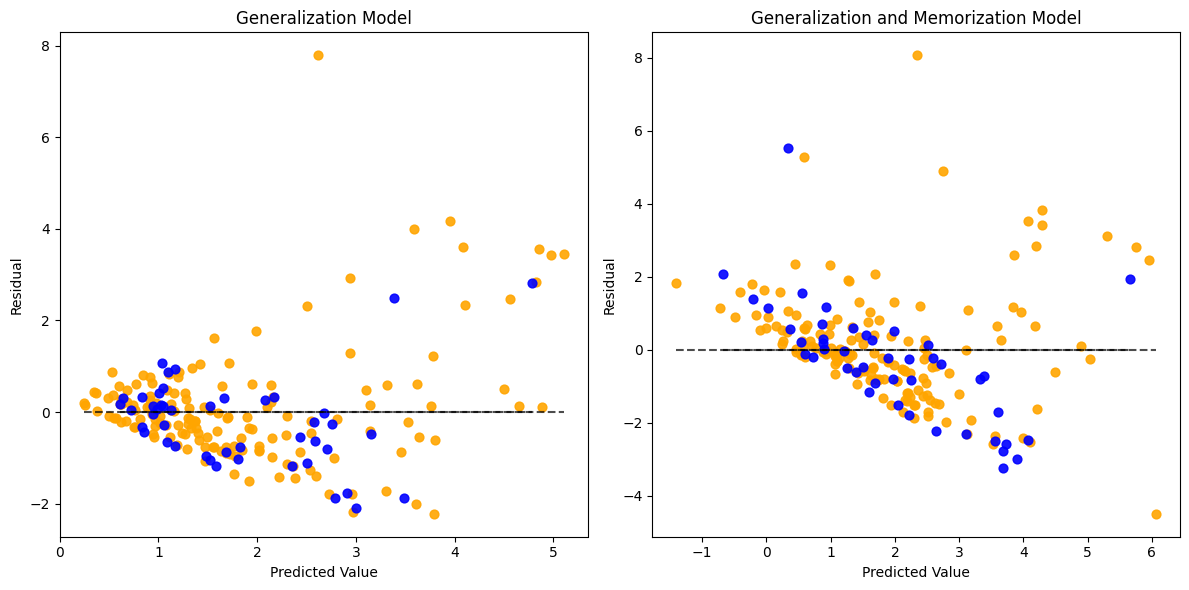

In [23]:
from sklearn.metrics import PredictionErrorDisplay

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for training data
PredictionErrorDisplay.from_predictions(
    y_train,
    y_train_pred_model_1.flatten(),
    ax=axs[0],
    kind="residual_vs_predicted",
    scatter_kwargs={"alpha": 0.9, "color": 'orange', "s": 40},
)
axs[0].set_xlabel("Predicted Value")
axs[0].set_ylabel("Residual")

# Plot for test data
PredictionErrorDisplay.from_predictions(
    y_test,
    y_test_pred_model_1.flatten(),
    ax=axs[0],
    kind="residual_vs_predicted",
    scatter_kwargs={"alpha": 0.9, "color": 'blue', "s": 40},
)
axs[0].set_title("Generalization Model")
axs[0].set_xlabel("Predicted Value")
axs[0].set_ylabel("Residual")




# Plot for training data
PredictionErrorDisplay.from_predictions(
    y_train,
    y_train_pred_model_2.flatten(),
    ax=axs[1],
    kind="residual_vs_predicted",
    scatter_kwargs={"alpha": 0.9, "color": 'orange', "s": 40},
)
axs[1].set_xlabel("Predicted Value")
axs[1].set_ylabel("Residual")

# Plot for test data
PredictionErrorDisplay.from_predictions(
    y_test,
    y_test_pred_model_2.flatten(),
    ax=axs[1],
    kind="residual_vs_predicted",
    scatter_kwargs={"alpha": 0.9, "color": 'blue', "s": 40},
)
axs[1].set_title("Generalization and Memorization Model")
axs[1].set_xlabel("Predicted Value")
axs[1].set_ylabel("Residual")

plt.tight_layout()
plt.show()


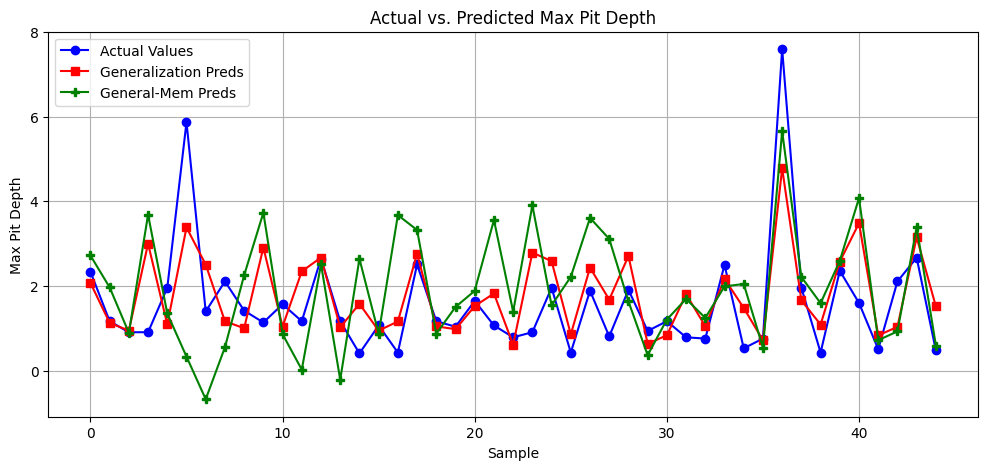

In [24]:
# Create a figure and axis object with a specified size for plotting.
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the actual test values against their sample indices.
ax.plot(range(len(y_test)), y_test, label='Actual Values', marker="o", color="blue")

# Plot the predicted test values from Model 1 (Generalization) against their sample indices.
ax.plot(range(len(y_test)), y_test_pred_model_1, label='Generalization Preds', marker="s", color="red")

# Plot the predicted test values from Model 2 (Generalization and Memorization) against their sample indices.
ax.plot(range(len(y_test)), y_test_pred_model_2, label='General-Mem Preds', marker="P", color="green")

# Add a legend to the plot to distinguish between the different lines.
ax.legend()

# Set the x-axis label to indicate the sample indices.
ax.set_xlabel("Sample")

# Set the y-axis label to indicate the Max Pit Depth values.
ax.set_ylabel("Max Pit Depth")

# Set the title of the plot to describe what is being compared.
ax.set_title("Actual vs. Predicted Max Pit Depth")

# Enable grid lines on the plot for better readability.
ax.grid()

# Display the plot.
plt.show()


In [19]:
# Download the dataset from the provided link
!wget https://raw.githubusercontent.com/HMesghali/Predictive-Deep-Learning-for-Pitting-Corrosion/main/SewagePipe_Data_Complete.csv

--2025-07-20 18:06:27--  https://raw.githubusercontent.com/HMesghali/Predictive-Deep-Learning-for-Pitting-Corrosion/main/SewagePipe_Data_Complete.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15543 (15K) [text/plain]
Saving to: ‘SewagePipe_Data_Complete.csv.1’

SewagePipe_Data_Com 100%[===================>]  15.18K  --.-KB/s    in 0.001s  

2025-07-20 18:06:27 (20.7 MB/s) - ‘SewagePipe_Data_Complete.csv.1’ saved [15543/15543]

